In [1]:
train_data_path = '/kaggle/input/omniglot/images_background/'
test_data_path = '/kaggle/input/omniglot/images_evaluation/'
n_way = 5
# n_way = 20
k_shot = 1
q_query = 5
outer_lr = 0.001
inner_lr = 0.04
meta_batch_size = 32
train_inner_step = 1
eval_inner_step = 3
# num_iterations = 1000
# num_iterations = 500
num_workers = 0
valid_size = 0.2
random_seed = 42
display_gap = 50

In [2]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=f610b6a97ccefa84d4412ce735694f709f70d2925385756111226974e037d920
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob
import torch
import random
import collections
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Subset
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
from torchvision.transforms import transforms
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock, self).__init__()
        self.conv2d = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv2d(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.max_pool(x)
        return x


def ConvBlockFunction(input, w, b, w_bn, b_bn):
    x = F.conv2d(input, w, b, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=w_bn, bias=b_bn, training=True)
    x = F.relu(x)
    output = F.max_pool2d(x, kernel_size=2, stride=2)

    return output


class Classifier(nn.Module):
    def __init__(self, in_ch, n_way):
        super(Classifier, self).__init__()
        self.conv1 = ConvBlock(in_ch, 64)
        self.conv2 = ConvBlock(64, 64)
        self.conv3 = ConvBlock(64, 64)
        self.conv4 = ConvBlock(64, 64)
        self.logits = nn.Linear(64, n_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.logits(x)
        return x

    def functional_forward(self, x, params):
        for block in [1, 2, 3, 4]:
            x = ConvBlockFunction(
                x,
                params[f"conv{block}.conv2d.weight"],
                params[f"conv{block}.conv2d.bias"],
                params.get(f"conv{block}.bn.weight"),
                params.get(f"conv{block}.bn.bias"),
            )
        x = x.view(x.shape[0], -1)
        x = F.linear(x, params["logits.weight"], params["logits.bias"])
        return x

In [5]:
maml_model = Classifier(in_ch=1, n_way=5)
maml_model.to(device)
optimizer = optim.Adam(maml_model.parameters(), outer_lr)
loss_fn = nn.CrossEntropyLoss().to(device)

checkpoint = torch.load('/kaggle/input/maml-5way-1shot-model/maml-para.pt') 
maml_model.load_state_dict(checkpoint)

/tmp/ipykernel_23/3481758512.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/maml-5way-1shot-model/maml-para.pt')


<All keys matched successfully>

In [6]:
ssl_model = Classifier(in_ch=1, n_way=5)
ssl_model.to(device)
optimizer = optim.Adam(ssl_model.parameters(), outer_lr)
loss_fn = nn.CrossEntropyLoss().to(device)

checkpoint = torch.load('/kaggle/input/ssl-maml-20way-1shot-250iters/maml-para.pt') 
ssl_model.load_state_dict(checkpoint)

/tmp/ipykernel_23/86581286.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/ssl-maml-5way-1shot/maml-para.pt')


<All keys matched successfully>

/tmp/ipykernel_23/3241598602.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  imgs = torch.tensor(imgs).float()  # Shape: [N, 1, 28, 28]


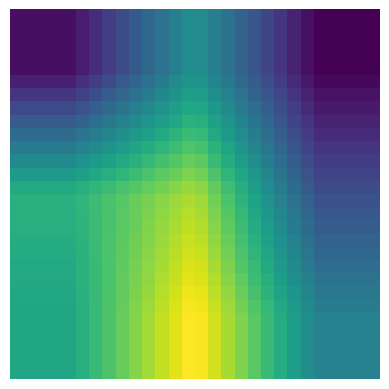

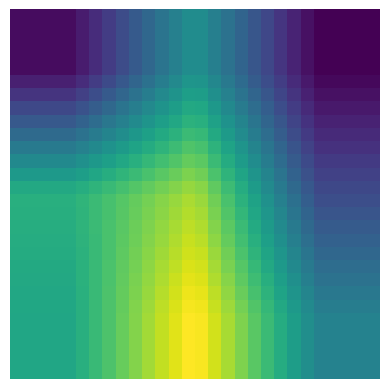

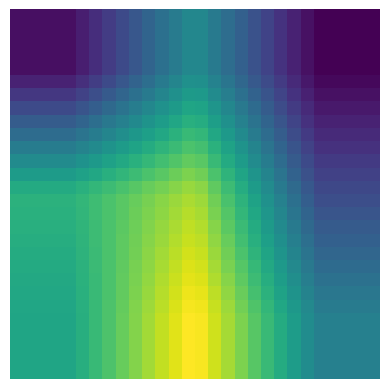

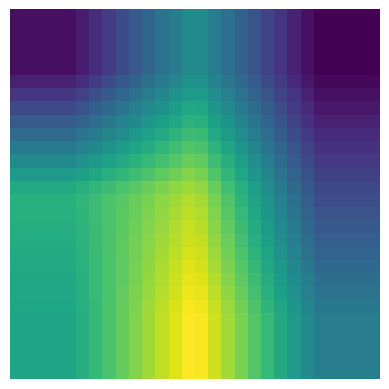

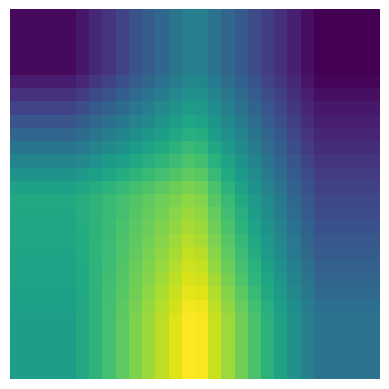

In [7]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgs_data = []
imgs = []
imgs_label = []

# Path to your test data (images directory)
# test_data_path = "path_to_your_images_directory"  # Adjust this path

# Fetch all the image paths
# img_list = [f for f in glob.glob(test_data_path + "**/*.png", recursive=True)]
# img_list = random.sample(img_list, 5)
# for path in img_list:
    # print(path)
# print(img_list)
img_list = ['/kaggle/input/omniglot/images_evaluation/Atlantean/character05/1015_18.png',
'/kaggle/input/omniglot/images_evaluation/Tibetan/character27/1582_16.png',
'/kaggle/input/omniglot/images_evaluation/Sylheti/character08/1510_07.png',
'/kaggle/input/omniglot/images_evaluation/Avesta/character02/1064_20.png',
'/kaggle/input/omniglot/images_evaluation/Oriya/character24/1457_12.png']

# Resize images to 28x28 and normalize them
for label, img_path in enumerate(img_list):
    image = transforms.Resize(size=28)(Image.open(img_path))  # Resize image to 28x28
    image = np.array(image)  # Convert to numpy array
    image = np.expand_dims(image / 255., axis=0)  # Normalize and add a channel dimension (1, 28, 28)
    
    imgs_data.append((image, label))

# Convert the data into torch tensors
for data in imgs_data:
    imgs.append(data[0])
    imgs_label.append(data[1])

# Convert images to a single tensor and labels to tensor
imgs = torch.tensor(imgs).float()  # Shape: [N, 1, 28, 28]
imgs_label = torch.tensor(imgs_label).long()  # Shape: [N]

# Move data to the correct device (GPU or CPU)
imgs = imgs.to(device)
imgs_label = imgs_label.to(device)


for i in range(len(imgs)):
    image = imgs[i].unsqueeze(0)  # Add batch dimension: [1, 1, 28, 28]
    label = imgs_label[i].item() 
    # x1, x2, x3, x4, final_output = model(image, return_intermediate=True)
    maml_model.eval()

    target_layers = [maml_model.conv4.conv2d]  # We will use the last convolution layer in the chain
    
    # Initialize GradCAM
    cam = GradCAM(model=maml_model, target_layers=target_layers)
    
    # Define the target class. You can either pass a specific class index or let it use the top prediction.
    # Here we assume we want the class with the highest score.
    output = maml_model(image)
    target_class = output.argmax(dim=1).item()  # Get the predicted class
    
    targets = [ClassifierOutputTarget(target_class)]
    
    # Generate the Grad-CAM
    grayscale_cam = cam(input_tensor=image, targets=targets)
    
    # Visualize and save the Grad-CAM on the image
    grayscale_cam = grayscale_cam[0, :]  # Assuming single image batch
    # rgb_img = np.array(image.squeeze(0).cpu())  # Normalize the image to [0, 1]
    # rgb_img = rgb_img.repeat([3, 1, 1]) 
    # rgb_img = rgb_img / rgb_img.max()
    # rgb_image = np.repeat(rgb_img, 3, axis=-1)
    # rgb_img = rgb_img.repeat(3, 1, 1)
    # print(rgb_img.shape)
    # Apply the CAM on the original image
    # visualization = overlay_cam_on_image(rgb_img, grayscale_cam, alpha=0.6)
    output_dir = "grad_cam_outputs/maml/"
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, f"grad_cam_image{i}_{target_class}.png")
    plt.imshow(grayscale_cam)
    plt.axis('off')
    plt.show()
    plt.imsave(save_path, grayscale_cam)
    # save_path_ = os.path.join(output_dir, f"original_image{i}_{target_class}.png")
    # image = image.squeeze(0).cpu().numpy()
    # cv2.imshow('Original Image', image)
    # cv2.imwrite(save_path, image)


    

    
#     gray_heatmap = grayscale_cam
# # Assuming 'heatmap' is your color heatmap as a NumPy array
#     gray_heatmap = cv2.cvtColor(gray_heatmap, cv2.COLOR_BGR2GRAY)
#     gray_heatmap = gray_heatmap / 255.0

#     alpha = 0.5  # Adjust the transparency
#     superimposed_image = cv2.addWeighted(original_image, 1 - alpha, gray_heatmap, alpha, 0)

# # Display or save the superimposed image
#     cv2.imshow('Superimposed Image', superimposed_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     save_path_ = os.path.join(output_dir, f"superimposed_image{i}_{target_class}.png")
#     cv2.imsave(save_path_, superimposed_image)
    
    # # Save the result
    # save_path = os.path.join(output_dir, f"grad_cam_image_{target_class}.png")
    # Image.fromarray((visualization * 255).astype(np.uint8)).save(save_path)
    
    
    # Save the result
    
    # Image.fromarray((visualization * 255).astype(np.uint8)).save(save_path)
    # print(f"Grad-CAM image saved to {save_path}")
    

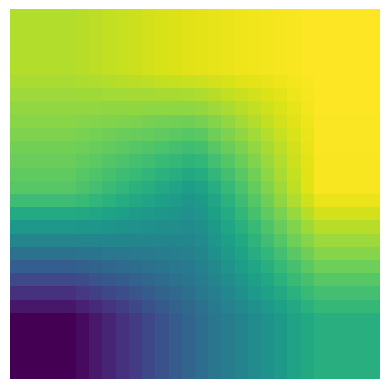

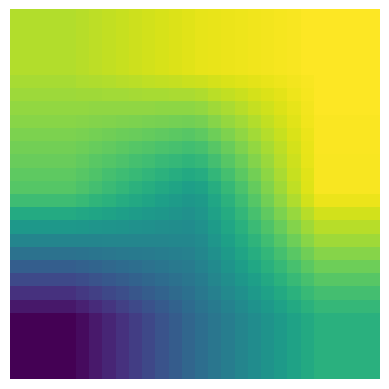

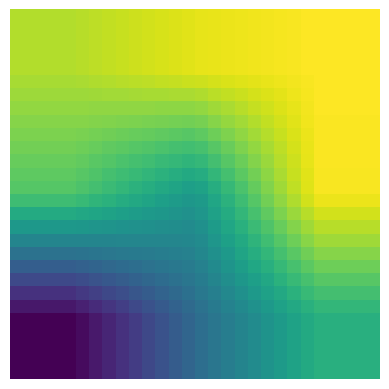

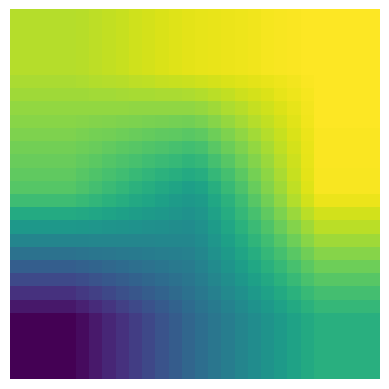

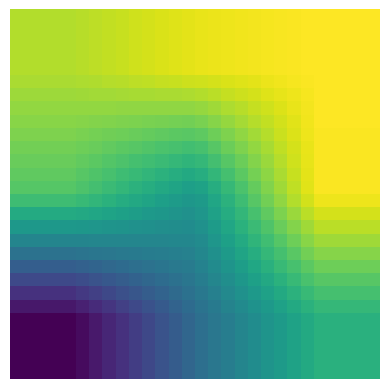

In [8]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgs_data = []
imgs = []
imgs_label = []

# Path to your test data (images directory)
# test_data_path = "path_to_your_images_directory"  # Adjust this path

# Fetch all the image paths
# img_list = [f for f in glob.glob(test_data_path + "**/*.png", recursive=True)]
# img_list = random.sample(img_list, 5)
# for path in img_list:
    # print(path)
# print(img_list)
img_list = ['/kaggle/input/omniglot/images_evaluation/Atlantean/character05/1015_18.png',
'/kaggle/input/omniglot/images_evaluation/Tibetan/character27/1582_16.png',
'/kaggle/input/omniglot/images_evaluation/Sylheti/character08/1510_07.png',
'/kaggle/input/omniglot/images_evaluation/Avesta/character02/1064_20.png',
'/kaggle/input/omniglot/images_evaluation/Oriya/character24/1457_12.png']

# Resize images to 28x28 and normalize them
for label, img_path in enumerate(img_list):
    image = transforms.Resize(size=28)(Image.open(img_path))  # Resize image to 28x28
    image = np.array(image)  # Convert to numpy array
    image = np.expand_dims(image / 255., axis=0)  # Normalize and add a channel dimension (1, 28, 28)
    
    imgs_data.append((image, label))

# Convert the data into torch tensors
for data in imgs_data:
    imgs.append(data[0])
    imgs_label.append(data[1])

# Convert images to a single tensor and labels to tensor
imgs = torch.tensor(imgs).float()  # Shape: [N, 1, 28, 28]
imgs_label = torch.tensor(imgs_label).long()  # Shape: [N]

# Move data to the correct device (GPU or CPU)
imgs = imgs.to(device)
imgs_label = imgs_label.to(device)


for i in range(len(imgs)):
    image = imgs[i].unsqueeze(0)  # Add batch dimension: [1, 1, 28, 28]
    label = imgs_label[i].item() 
    # x1, x2, x3, x4, final_output = model(image, return_intermediate=True)
    ssl_model.eval()

    target_layers = [ssl_model.conv4.conv2d]  # We will use the last convolution layer in the chain
    
    # Initialize GradCAM
    cam = GradCAM(model=ssl_model, target_layers=target_layers)
    
    # Define the target class. You can either pass a specific class index or let it use the top prediction.
    # Here we assume we want the class with the highest score.
    output = ssl_model(image)
    target_class = output.argmax(dim=1).item()  # Get the predicted class
    
    targets = [ClassifierOutputTarget(target_class)]
    
    # Generate the Grad-CAM
    grayscale_cam = cam(input_tensor=image, targets=targets)
    
    # Visualize and save the Grad-CAM on the image
    grayscale_cam = grayscale_cam[0, :]  # Assuming single image batch
    # rgb_img = np.array(image.squeeze(0).cpu())  # Normalize the image to [0, 1]
    # rgb_img = rgb_img.repeat([3, 1, 1]) 
    # rgb_img = rgb_img / rgb_img.max()
    # rgb_image = np.repeat(rgb_img, 3, axis=-1)
    # rgb_img = rgb_img.repeat(3, 1, 1)
    # print(rgb_img.shape)
    # Apply the CAM on the original image
    # visualization = overlay_cam_on_image(rgb_img, grayscale_cam, alpha=0.6)
    output_dir = "grad_cam_outputs/ssl/"
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, f"grad_cam_image{i}_{target_class}.png")
    plt.imshow(grayscale_cam)
    plt.axis('off')
    plt.show()
    plt.imsave(save_path, grayscale_cam)
    # save_path_ = os.path.join(output_dir, f"original_image{i}_{target_class}.png")
    # image = image.squeeze(0).cpu().numpy()
    # cv2.imshow('Original Image', image)
    # cv2.imwrite(save_path, image)


    

    
#     gray_heatmap = grayscale_cam
# # Assuming 'heatmap' is your color heatmap as a NumPy array
#     gray_heatmap = cv2.cvtColor(gray_heatmap, cv2.COLOR_BGR2GRAY)
#     gray_heatmap = gray_heatmap / 255.0

#     alpha = 0.5  # Adjust the transparency
#     superimposed_image = cv2.addWeighted(original_image, 1 - alpha, gray_heatmap, alpha, 0)

# # Display or save the superimposed image
#     cv2.imshow('Superimposed Image', superimposed_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     save_path_ = os.path.join(output_dir, f"superimposed_image{i}_{target_class}.png")
#     cv2.imsave(save_path_, superimposed_image)
    
    # # Save the result
    # save_path = os.path.join(output_dir, f"grad_cam_image_{target_class}.png")
    # Image.fromarray((visualization * 255).astype(np.uint8)).save(save_path)
    
    
    # Save the result
    
    # Image.fromarray((visualization * 255).astype(np.uint8)).save(save_path)
    # print(f"Grad-CAM image saved to {save_path}")
    